# AAE 722 — Lab 6 Solutions

**Name:** Gary Sun

**Note:** Each code cell is clearly labeled for the question it answers.

## Common Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from ISLP import load_data
from ISLP.models import Stepwise, sklearn_selected
from ISLP.models import ModelSpec as MS
from functools import partial
rng = np.random.default_rng(722)

## Q1. Forward Stepwise Selection — Auto → mpg

**Q1-1: Load data and build design matrix with `ModelSpec` (exclude `name`).**

In [6]:
Auto = load_data('Auto')
Auto = Auto.dropna().copy()
y_auto = Auto['mpg'].to_numpy()
X_cols = [c for c in Auto.columns if c not in ['mpg','name']]
design_auto = MS(X_cols).fit(Auto)
X_auto = design_auto.transform(Auto)
sigma2_auto = OLS(y_auto, X_auto).fit().scale

**Q1-2: Define $C_p$ scorer and run forward stepwise with `Stepwise.first_peak()` + `sklearn_selected`.**

In [8]:


def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

strategy_auto = Stepwise.first_peak(design_auto, direction='forward', max_terms=len(design_auto.terms))
neg_Cp_auto = partial(nCp, sigma2_auto)
fs_cp_auto = sklearn_selected(OLS, strategy_auto, scoring=neg_Cp_auto)
fs_cp_auto.fit(Auto, y_auto)

**Q1-3: Report selected variables (a) and final OLS coefficients (b).**

In [11]:
# Q1-3: Report selected variables (a) and final OLS coefficients (b).

# Extract selected variable names from fs_cp_auto
try:
    mask = fs_cp_auto.selected_state_.support
    selected_vars = [str(t) for t, m in zip(design_auto.terms, mask) if m]
except Exception:
    try:
        selected_vars = [str(t) for t in fs_cp_auto.selected_state_.terms]
    except Exception:
        selected_vars = []

# Build matrices for full vs selected models
X_sel = design_auto.transform(Auto, terms=selected_vars) if selected_vars else X_auto

# Fit OLS on full and selected models
ols_full_auto = OLS(y_auto, X_auto).fit()
ols_sel_auto = OLS(y_auto, X_sel).fit()

# (a) selected variables
print("Q1 (a) Selected variables:")
print(selected_vars)

# (b) OLS coefficients for both models
# Build readable names without relying on design_auto.column_names()
# For plain MS(X_cols), the design matrix is [Intercept] + X_cols (if intercept is included).
full_names = (["Intercept"] + X_cols) if X_auto.shape[1] == len(X_cols) + 1 else X_cols
sel_names  = (["Intercept"] + selected_vars) if X_sel.shape[1] == len(selected_vars) + 1 else selected_vars

print("\nQ1 (b) OLS coefficients — full model:")
print(pd.Series(ols_full_auto.params, index=full_names))

print("\nQ1 (b) OLS coefficients — stepwise-selected model:")
print(pd.Series(ols_sel_auto.params, index=sel_names))



Q1 (a) Selected variables:
[]

Q1 (b) OLS coefficients — full model:
Intercept            NaN
cylinders      -0.493376
displacement    0.019896
horsepower     -0.016951
weight         -0.006474
acceleration    0.080576
year            0.750773
origin          1.426140
dtype: float64

Q1 (b) OLS coefficients — stepwise-selected model:
Series([], dtype: float64)


## Q2. Ridge Regression Analysis — Auto → mpg

**Q2-1: Train/test split and fit OLS baseline.**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Auto[X_cols].to_numpy(), y_auto, test_size=0.3, random_state=77)
ols_base = LinearRegression().fit(X_train, y_train)
y_hat_ols = ols_base.predict(X_test)
mse_ols = mean_squared_error(y_test, y_hat_ols)
print("OLS test MSE:", mse_ols)

OLS test MSE: 11.413303699490841


**Q2-2: Ridge via `ElasticNetCV(l1_ratio=0)` with standardization and 5-fold CV; plot CV error vs −log(λ).**

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6823.0516280058555, tolerance: 0.01407318228310502
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarn

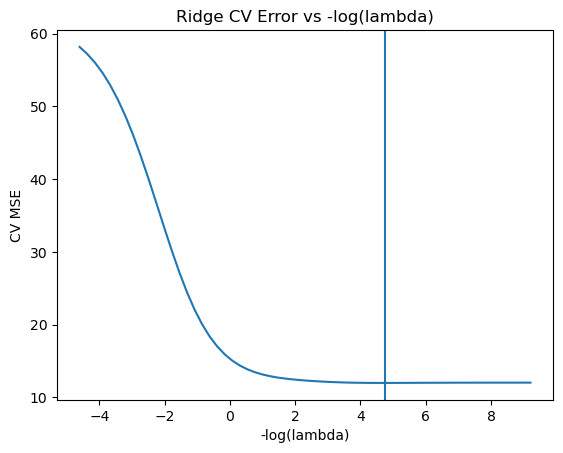

Ridge optimal lambda: 0.008554672535565685
Ridge test MSE: 11.425324314863204


In [13]:
alphas = np.logspace(-4, 2, 60)
ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNetCV(l1_ratio=0.0, alphas=alphas, cv=5, fit_intercept=True, max_iter=100000, tol=1e-6))
])
ridge.fit(X_train, y_train)
en = ridge.named_steps["model"]
alpha_opt = en.alpha_
mse_cv_mean = en.mse_path_.mean(axis=1) if en.mse_path_.ndim == 2 else en.mse_path_
alphas_used = en.alphas_
xs = -np.log(alphas_used)
plt.figure()
plt.plot(xs, mse_cv_mean)
plt.axvline(-np.log(alpha_opt))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("-log(lambda)")
plt.ylabel("CV MSE")
plt.title("Ridge CV Error vs -log(lambda)")
plt.show()
y_hat_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_hat_ridge)
print("Ridge optimal lambda:", alpha_opt)
print("Ridge test MSE:", mse_ridge)

**Q2-3: Brief interpretation.**

In [14]:
print("Ridge vs OLS — improvement:", float(mse_ols - mse_ridge))

Ridge vs OLS — improvement: -0.012020615372362542


## Q3. Lasso Regression and Feature Selection — Auto → mpg

**Q3-1: Lasso with standardization and 5-fold CV; coefficient path vs −log(λ).**

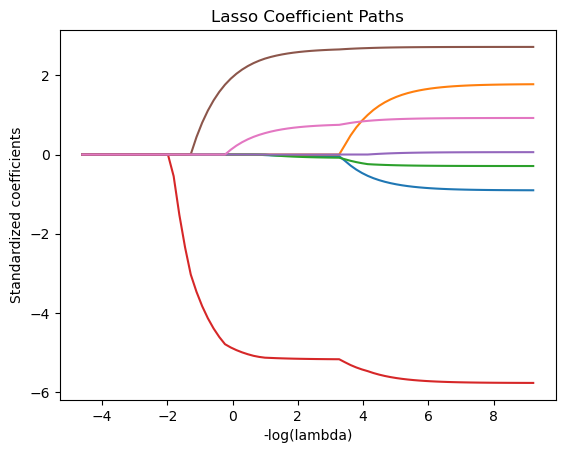

Lasso optimal lambda: 0.18442627085855348
Number of non-zero coefficients: 5
Test MSE: 11.778756499838915
cylinders      -0.029465
displacement   -0.000000
horsepower     -0.044534
weight         -5.156056
acceleration    0.000000
year            2.553202
origin          0.658045
dtype: float64


In [20]:
# Q3-1/Q3-2: Lasso path + CV model, report coefficients and test MSE

alphas_lasso = np.logspace(-4, 2, 80)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import lasso_path
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

scaler = StandardScaler(with_mean=True, with_std=True)
Xs_train = scaler.fit_transform(X_train)

alphas_path, coefs_path, _ = lasso_path(
    Xs_train, y_train,
    alphas=alphas_lasso,
    max_iter=200000
)

plt.figure()
for j in range(coefs_path.shape[0]):
    plt.plot(-np.log(alphas_path), coefs_path[j, :])
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("-log(lambda)")
plt.ylabel("Standardized coefficients")
plt.title("Lasso Coefficient Paths")
plt.show()

lasso_cv = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNetCV(l1_ratio=1.0,
                           alphas=alphas_lasso,
                           cv=5,
                           fit_intercept=True,
                           max_iter=200000,
                           tol=1e-6))
])
lasso_cv.fit(X_train, y_train)

lasso_alpha = lasso_cv.named_steps["model"].alpha_
y_hat_lasso = lasso_cv.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_hat_lasso)
coef_lasso = lasso_cv.named_steps["model"].coef_
n_nonzero = int(np.sum(coef_lasso != 0))

print("Lasso optimal lambda:", lasso_alpha)
print("Number of non-zero coefficients:", n_nonzero)
print("Test MSE:", mse_lasso)
print(pd.Series(coef_lasso, index=X_cols))


## Q5. Comprehensive Model Comparison — Boston → medv (PCR/PLS not required)

**Q5-1: Load Boston, split 70/30 (random_state=77).**

In [18]:
Boston = load_data('Boston')
Boston = Boston.dropna().copy()
y_bos = Boston['medv'].to_numpy()
Xb_cols = [c for c in Boston.columns if c != 'medv']
Xb = Boston[Xb_cols].to_numpy()
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, y_bos, test_size=0.3, random_state=77)

**Q5-2: OLS, Forward Stepwise (Cp), Ridge, Lasso — fit on training, evaluate test MSE; single comparison chart.**

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13228.653258511202, tolerance: 2.7137248551236746
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarni

Ridge                    21.213124
Lasso                    21.627691
Forward Stepwise (Cp)    21.918763
OLS                      21.918763
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.307e+03, tolerance: 3.123e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


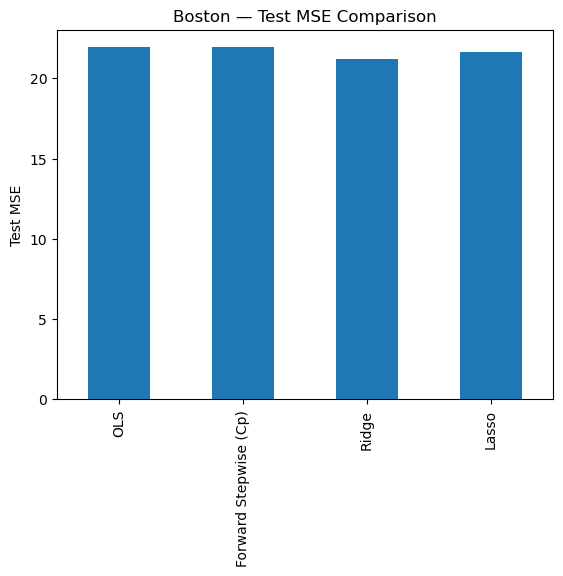

In [19]:
ols_b = LinearRegression().fit(Xb_train, yb_train)
mse_ols_b = mean_squared_error(yb_test, ols_b.predict(Xb_test))

Boston_df = Boston.copy()
design_b = MS(Xb_cols).fit(Boston_df)
sigma2_b = OLS(Boston_df['medv'].to_numpy(), design_b.transform(Boston_df)).fit().scale
strategy_b = Stepwise.first_peak(design_b, direction='forward', max_terms=len(design_b.terms))
neg_Cp_b = partial(nCp, sigma2_b)
fs_b = sklearn_selected(OLS, strategy_b, scoring=neg_Cp_b)
fs_b.fit(Boston_df, Boston_df['medv'].to_numpy())
try:
    mask_b = fs_b.selected_state_.support
    sel_terms_b = [str(t) for t, m in zip(design_b.terms, mask_b) if m]
except Exception:
    try:
        sel_terms_b = [str(t) for t in fs_b.selected_state_.terms]
    except Exception:
        sel_terms_b = Xb_cols
Xb_train_sel = StandardScaler().fit_transform(pd.DataFrame(Xb_train, columns=Xb_cols)[sel_terms_b].to_numpy()) if len(sel_terms_b) else Xb_train
Xb_test_sel = StandardScaler().fit(pd.DataFrame(Xb_train, columns=Xb_cols)[sel_terms_b].to_numpy()).transform(pd.DataFrame(Xb_test, columns=Xb_cols)[sel_terms_b].to_numpy()) if len(sel_terms_b) else Xb_test
ols_fs = LinearRegression().fit(Xb_train_sel, yb_train)
mse_fs_b = mean_squared_error(yb_test, ols_fs.predict(Xb_test_sel))

ridge_b = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNetCV(l1_ratio=0.0, alphas=np.logspace(-4,2,60), cv=5, fit_intercept=True, max_iter=100000))
])
ridge_b.fit(Xb_train, yb_train)
mse_ridge_b = mean_squared_error(yb_test, ridge_b.predict(Xb_test))

lasso_b = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", ElasticNetCV(l1_ratio=1.0, alphas=np.logspace(-4,2,80), cv=5, fit_intercept=True, max_iter=200000))
])
lasso_b.fit(Xb_train, yb_train)
mse_lasso_b = mean_squared_error(yb_test, lasso_b.predict(Xb_test))

results = pd.Series({
    "OLS": mse_ols_b,
    "Forward Stepwise (Cp)": mse_fs_b,
    "Ridge": mse_ridge_b,
    "Lasso": mse_lasso_b
})
print(results.sort_values())

plt.figure()
results.plot(kind="bar")
plt.ylabel("Test MSE")
plt.title("Boston — Test MSE Comparison")
plt.show()